# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline

from time import time
import os
import math
from six.moves import cPickle as pickle

import cv2
import matplotlib.pylab as plt
import matplotlib.image as mpimg

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit

# contains all the utility functions used in this notebook
from utils import *

In [2]:
# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_train_src, X_test_src = train['sizes'], test['sizes']
X_train_co, X_test_co = train['coords'], test['coords']

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

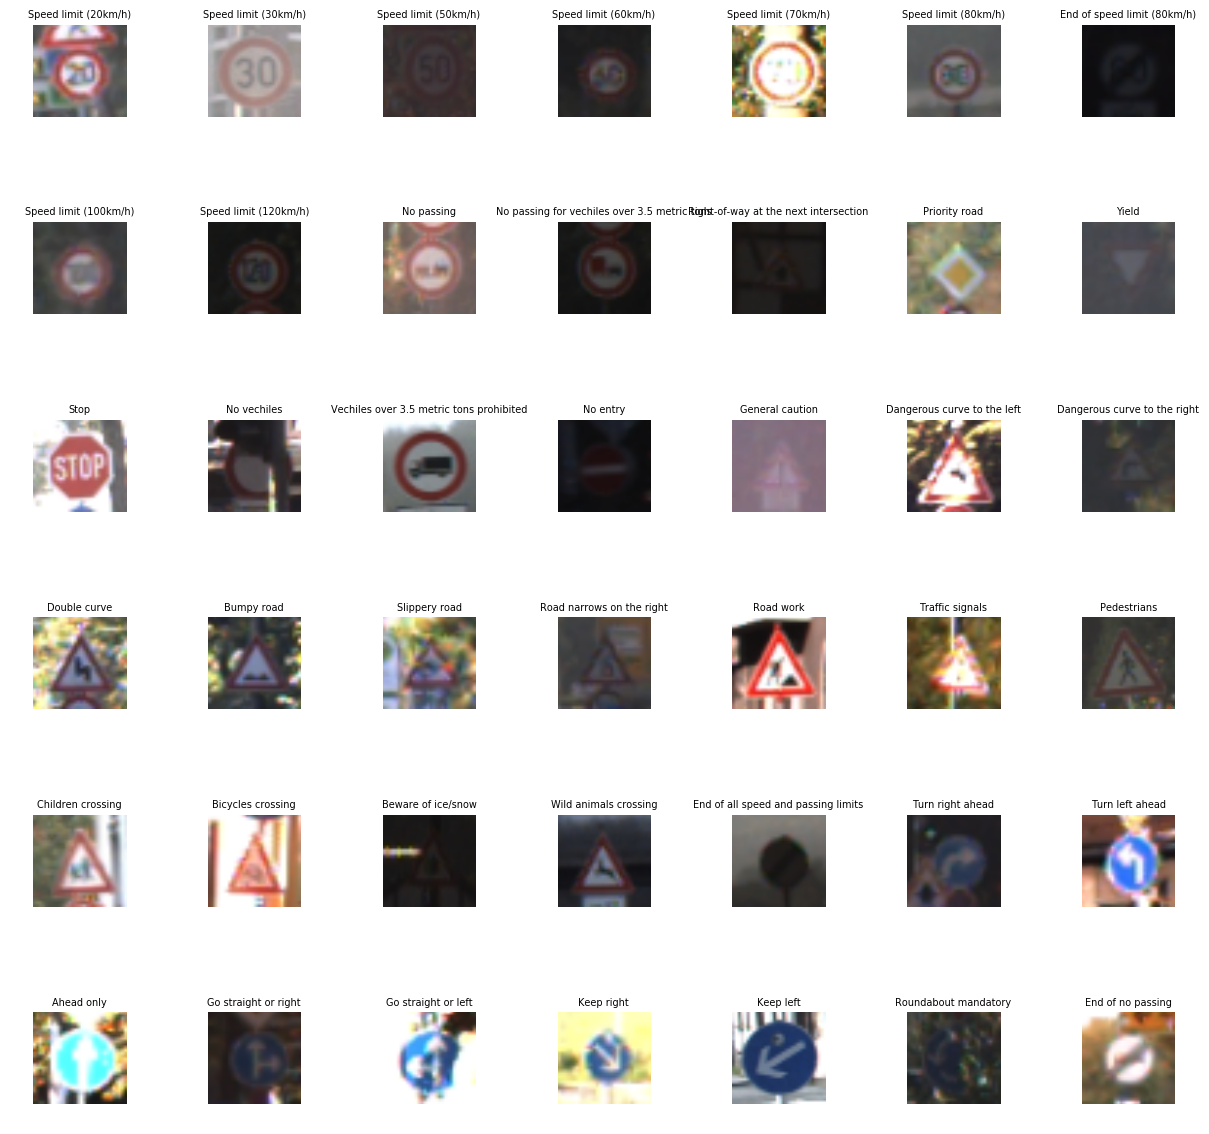

In [5]:
# Lets first take a look at the images individually:
images, labels = get_unique_images(X_train, y_train)
plot_images(images, labels)

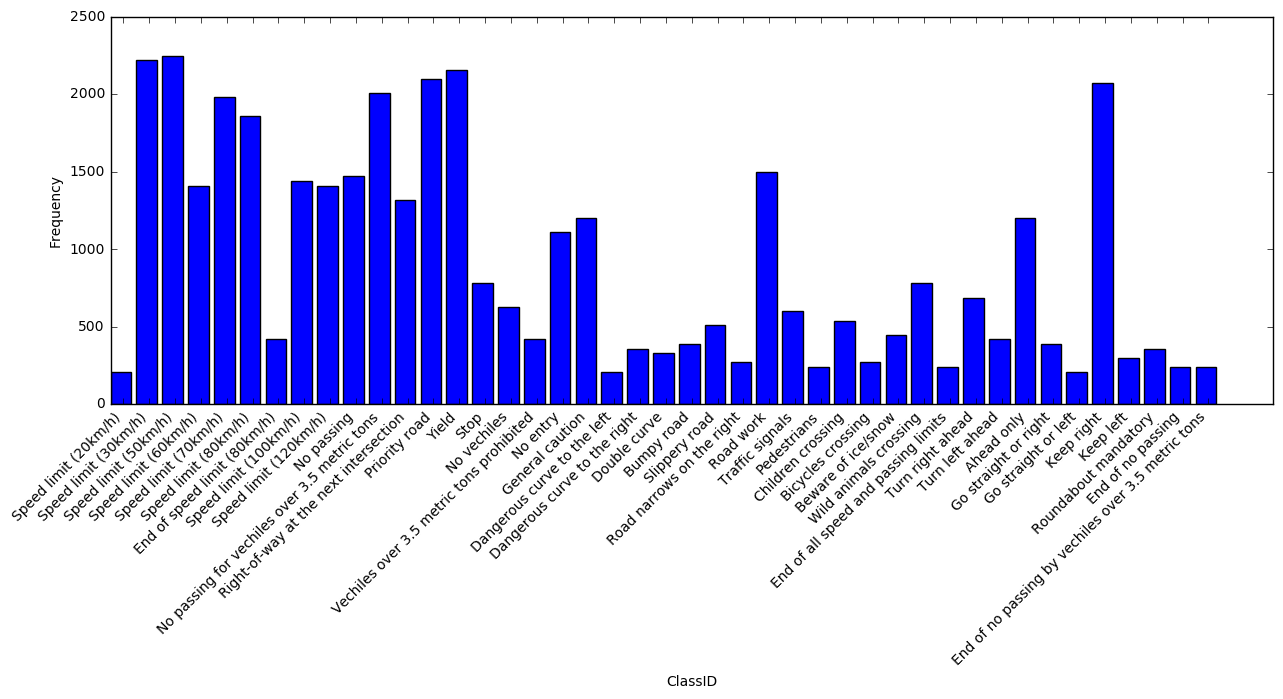

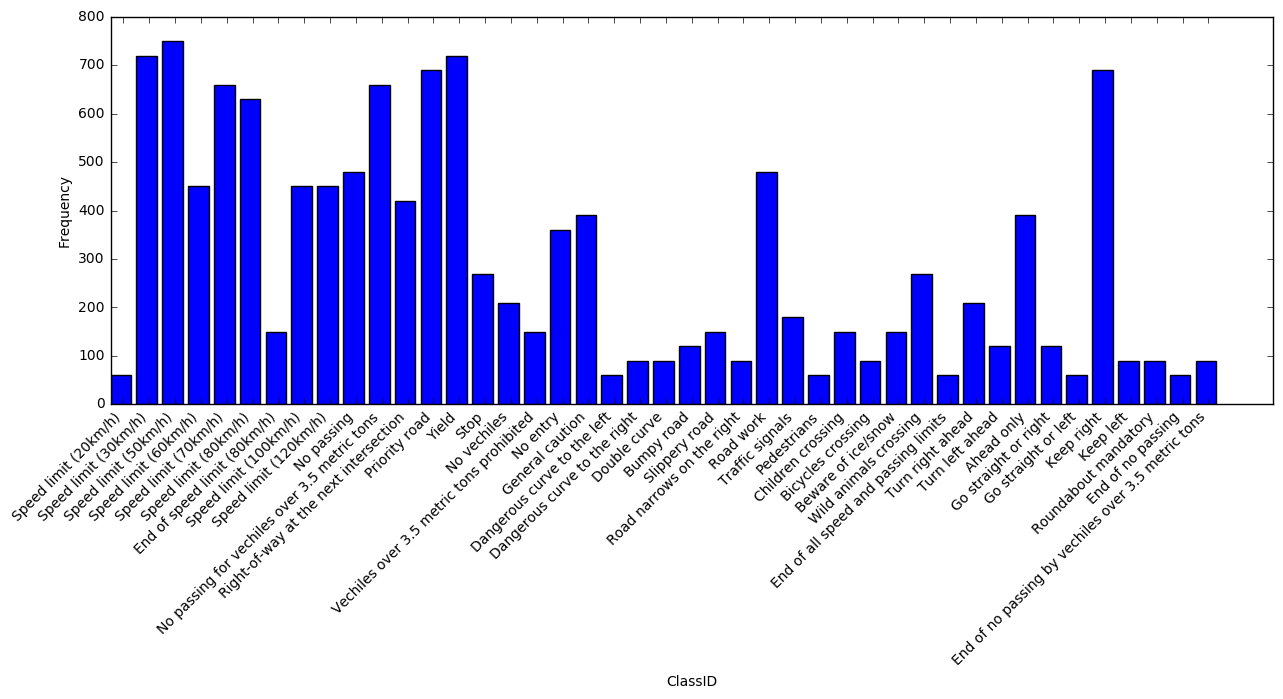

In [6]:
# Lets take a look at the distribution of classes in the training and test dataset.
plot_class_frequencies(y_train)
plot_class_frequencies(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:

X_train = np.array([pre_process(image, box, src ) for
                    image, box, src in
                    zip(X_train, X_train_co, X_train_src)],
                   dtype=np.float32)
X_test = np.array([pre_process(image, box, src) for 
                   image, box, src in
                   zip(X_test, X_test_co, X_test_src)],
                  dtype=np.float32)

train_labels = dense_to_one_hot(y_train, n_classes=43)
test_labels = dense_to_one_hot(y_test, n_classes=43)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

The data has not been pre-processed too much. I believe that DNNs are supposed to be able to learn their own features and must be able to do so on raw data. However, I have performed normalization that brings the data to a 0.1 to 0.9 scale, this makes the calculations smaller and easier. Further, the images were scaled upto 48\*48  from the original 32\*32 dimensions to be able to use them in the architecture proposed.

As noticed from the class distribution visualization there is a class imbalance issue. This is addressed by the data augmentation implemented later.
The labels were also one-hot-encoded at this stage.

Disclaimer: All of these pre-processing techniques have been inspired from [ Dan Cire¸ et al. Multi-Column Deep Neural Network for Traffic Sign Classification](http://people.idsia.ch/~juergen/nn2012traffic.pdf)

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
batch_size = 100
epochs = 200
cv_generator = StratifiedShuffleSplit(n_splits=epochs, test_size=0.1, random_state=42)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I have decided to use the [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) for my cross-validation. This was preferred over the traditional train-test-split because  I get to use the entire training data and have data for cross-validation while keeping the distribution of the labels in both similar. Around 1% of the data will be used for the cross-validation set.

The data is augmented at runtime, this is acheived by pre-process the data and randomly sampling from it through batches. The sampled data is first translated within the range `(0.9 and 1.1)` then resized within the range `(0.9 and 1.1)` and then rotated within &plusmn;15&deg;

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
image_shape = 48
num_channels = 3
features_count = image_shape*image_shape*num_channels
labels_count = 43

features = tf.placeholder(tf.float32, shape=[None, features_count])
feature_tensor = tf.reshape(features, shape=[-1, image_shape, image_shape, num_channels])
labels = tf.placeholder(tf.float32, shape=[None, labels_count])
drop_probs = tf.placeholder(tf.float32)

def get_model(*inputs):
    features, feature_tensor, labels, drop_probs, num_channels = inputs
    layer_1 = conv_layer(input_layer=feature_tensor,
                         num_input_channels=num_channels,
                         kernel_size=7,
                         num_filters=100,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_2 = conv_layer(input_layer=layer_1,
                         num_input_channels=100,
                         kernel_size=4,
                         num_filters=150,
                         padding = 'VALID',
                         use_pooling=True
                         )
    layer_3 = conv_layer(input_layer=layer_2,
                         num_input_channels=150,
                         kernel_size=4,
                         num_filters=250,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_3_flat, layer_3_flat_count = flatten_layer(layer_3)

    layer_4, layer_4_l2 = fc_layer(input_layer = layer_3_flat,
                                   num_inputs = layer_3_flat_count,
                                   num_outputs = 300,
                                   use_relu=True,
                                   l2 = True,
                                   dropout = True,
                                   keep_prob = drop_probs
                                   )

    layer_5, layer_5_l2 = fc_layer(input_layer=layer_4,
                                   num_inputs=300,
                                   num_outputs=labels_count,
                                   use_relu=True,
                                   l2 = True,
                                   dropout = False,
                                   keep_prob = drop_probs
                                   )

    regularizers = layer_4_l2 + layer_5_l2


    predictions = tf.nn.softmax(layer_5)
    cross_entorpy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_5, labels=labels)
    loss = tf.reduce_mean(cross_entorpy)
    loss += 5e-4 * regularizers
    optimizer = tf.train.AdamOptimizer(5e-4).minimize(loss)
    return (predictions, loss, optimizer)
predictions, loss, optimizer = get_model(*[features, feature_tensor, labels, drop_probs, num_channels])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architecture is the same as mentioned in the reference [paper](http://people.idsia.ch/~juergen/nn2012traffic.pdf) with modifications to the Activation functions(RELU used instead of the original tanh since the image are normalizedd differently), and padding(`VALID` used instead of `SAME`) and additional `Dropout` and `L2 Regularization`

1. Input layer
2. Convolution layer -  kernel size = 7, num_filter = 100, padding = `VALID`, stride = 1
3. Max pooling layer - 2x2
4. `RELU` activation
5. Convolution layer -  kernel size = 4, num_filter = 150, padding = `VALID`, stride = 1
6. Max pooling layer - 2x2
7. `RELU` activation
5. Convolution layer -  kernel size = 4, num_filter = 250, padding = `VALID`, stride = 1
6. Max pooling layer - 2x2
7. `RELU` activation
8. Flatten Layer - activation = `RELU` , `l2_regularization of weights and biases`
9. Dropout - probability = 0.5
10. Fully Connected layer - 300 Neurons,  activation = `RELU` , `l2_regularization of weights and biases`
11. Softmax layer - 43 classes

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

def predict_class(in_features, in_labels, sess):
    batch_size = 500
    batch_count = int(math.ceil(len(in_features)/batch_size)) 
    class_predictions = np.zeros_like(in_labels)
    for i in range(batch_count):
        batch_start = i*batch_size
        batch_end = batch_start+batch_size
        batch_features = in_features[batch_start : batch_end]
        batch_labels = in_labels[batch_start : batch_end]
        feed_dict = {features: batch_features,
                     labels: batch_labels,
                     drop_probs: 1.0
                     }
        class_predictions[batch_start:batch_end] = sess.run(predictions, feed_dict=feed_dict)
    return class_predictions
    

In [11]:
saver = tf.train.Saver()
model_path = get_model_dir()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Model Initialized")
    batch_count = int(math.ceil(len(X_train)/batch_size))
    start_time = time()
    validation_accuracy_previous = 0
    try:
        for epoch, indices in zip(range(epochs), cv_generator.split(np.zeros_like(X_train),y_train)):
            train_index, valid_index = indices[0], indices[1]
            for batch_features, batch_labels in batch_generator(X_train[train_index],
                                                                train_labels[train_index],
                                                                batch_count,
                                                                batch_size):
                feed_dict = {features: batch_features,
                             labels: batch_labels,
                             drop_probs: 0.5
                             }
                _, l = sess.run([optimizer, loss], feed_dict=feed_dict)

            if epoch%5 == 0:
                X_train_flat = flatten_images(X_train)
                X_test_flat = flatten_images(X_test)

                time_taken = round((time() - start_time)/60.0 , 2)
                train_predictions = predict_class(in_features=X_train_flat[train_index],
                                                  in_labels=train_labels[train_index],
                                                  sess=sess)
                valid_predictions = predict_class(in_features=X_train_flat[valid_index],
                                                  in_labels=train_labels[valid_index],
                                                  sess=sess)
                test_predictions = predict_class(in_features=X_test_flat,
                                                 in_labels=test_labels,
                                                 sess=sess)
                training_accuracy = round(get_accuracy(train_predictions, train_labels[train_index]), 3)
                validation_accuracy = round(get_accuracy(valid_predictions, train_labels[valid_index]), 3)
                print("Time taken: {} mins for {} epochs. Training accuracy: {}, validation accuracy {}".
                      format(time_taken, epoch, training_accuracy, validation_accuracy))
                if abs(validation_accuracy_previous - validation_accuracy) < .01:
                    raise StopTraining
                else:
                    validation_accuracy_previous = validation_accuracy
                    
    except StopTraining:
        print("Training Stopped: Validation accuracy stabilized after {} epochs at {}".format(
                epoch, validation_accuracy))
        saver.save(sess, '{}/the_model'.format(model_path))
        print('model_saved at {}/the_model'.format(model_path))
        pass

Model Initialized
Time taken: 0.39 mins for 0 epochs. Training accuracy: 0.9300000071525574, validation accuracy 0.9290000200271606
Time taken: 2.43 mins for 5 epochs. Training accuracy: 0.996999979019165, validation accuracy 0.9959999918937683
Time taken: 4.46 mins for 10 epochs. Training accuracy: 0.9990000128746033, validation accuracy 0.9980000257492065
Training Stopped: Validation accuracy stabilized after 10 epochs at 0.9980000257492065
model_saved at /files/sdcnd/traffic-signs/model_dir/the_model


In [12]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('{}/the_model.meta'.format(model_path))
    saver.restore(sess, tf.train.latest_checkpoint('{}'.format(model_path)))
    X_train_flat = flatten_images(X_train)
    X_test_flat = flatten_images(X_test)
    
    train_predictions = predict_class(in_features=X_train_flat[train_index],
                                      in_labels=train_labels[train_index],
                                      sess=sess)
    valid_predictions = predict_class(in_features=X_train_flat[valid_index],
                                      in_labels=train_labels[valid_index],
                                      sess=sess)
    test_predictions = predict_class(in_features=X_test_flat,
                                     in_labels=test_labels,
                                     sess=sess)

In [13]:
training_accuracy = get_accuracy(train_predictions, train_labels[train_index])
validation_accuracy = get_accuracy(valid_predictions, train_labels[valid_index])
test_accuracy = get_accuracy(test_predictions, test_labels)
print('Training Accuracy: {}'.format(round(training_accuracy, 3)))
print('Validation Accuracy: {}'.format(round(validation_accuracy, 3)))
print('Test Accuracy: {}'.format(round(test_accuracy, 3)))

Training Accuracy: 0.9990000128746033
Validation Accuracy: 0.9980000257492065
Test Accuracy: 0.9710000157356262


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used `AdamOptimizer` at a `learning_rate` of `5e-4` with a `batch size` of `100`. I automated the process to stop the training once the validation accuracy stabilizes i.e. it doesn't change after 5 epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I initialy created a simple single layer fully connected neural network with a logistic regression layer and began stacking new convolution layers as suggested in the [reference](http://people.idsia.ch/~juergen/nn2012traffic.pdf). Furthermore, it included Image augmentation functions for input data. This gave me access to unlimited data for training. However, I noticed that the network was overfitting and included Dropout and L2 regularization to combat this.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

Please refer to additional notebook - `./process_test_images.ipynb` in the project directory. I have pre-processed the images and created a pickle-file. Similar to the one we have for the train and test images.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
I chose the images from a random google search for images for the search-term `"Traffic Signs"`. The images were not annotated like the training/test images and I performed maual annotation and cropping on them in the abovementioned notebook. Furthermore, there were some images with an additional transparency channel which was also changed to a 3 channel RGB image. Once the images were cropped and brought to a standard shape they were written into a pickle file as a numpy array. Below I pre-process the images as I did with the training set. Normalizing them within the range 0.0 and 1.0

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with open('new_test.p', 'rb') as n_file:
    candidates = pickle.load(n_file)

In [16]:
candidates = np.array([pre_process(image) for image in candidates], dtype=np.float32)

In [17]:
top_5 = tf.nn.top_k(input=predictions, k=5, sorted=True)
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('{}/the_model.meta'.format(model_path))
    saver.restore(sess, tf.train.latest_checkpoint('{}'.format(model_path)))
    X_candidate = flatten_images(candidates)   
    feed_dict = {features: X_candidate,
                 drop_probs: 1.0
                 }
    top_predictions = sess.run(top_5, feed_dict=feed_dict)

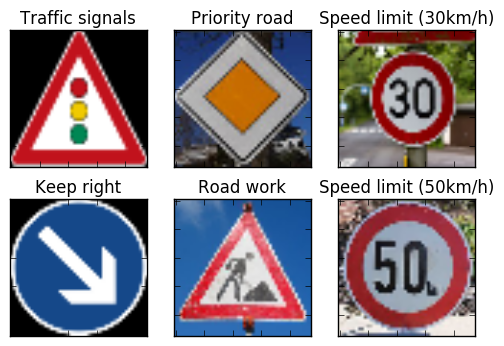

In [18]:
top_labels = []
for labels in top_predictions.indices :
    top_labels.append(get_label_map('signnames.csv', labels))

_, axs = plt.subplots(2,3)
axs = axs.ravel()
plt.figure(figsize=(2,2));
for i, (candidate, label) in enumerate(zip(candidates, top_labels)):
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].imshow(candidate)
    axs[i].set_title(label[0])
    # plt.title(label[0])
plt.show();

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Yes, the model performs well on all the captured images. I have not added any labels to measure the accuracy and believe that I should be able to manually judge the performance of the model from the label it provides.

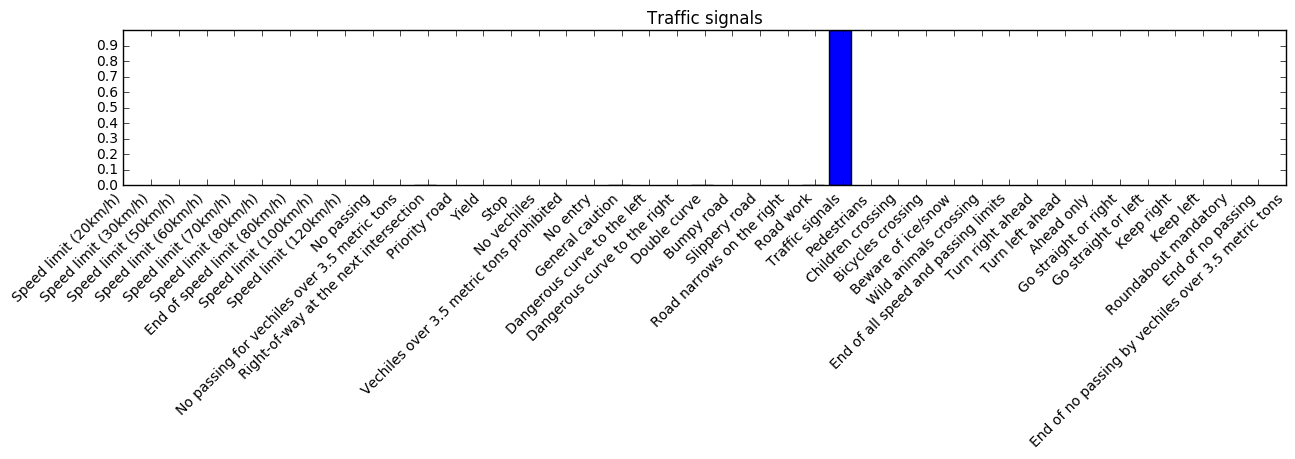

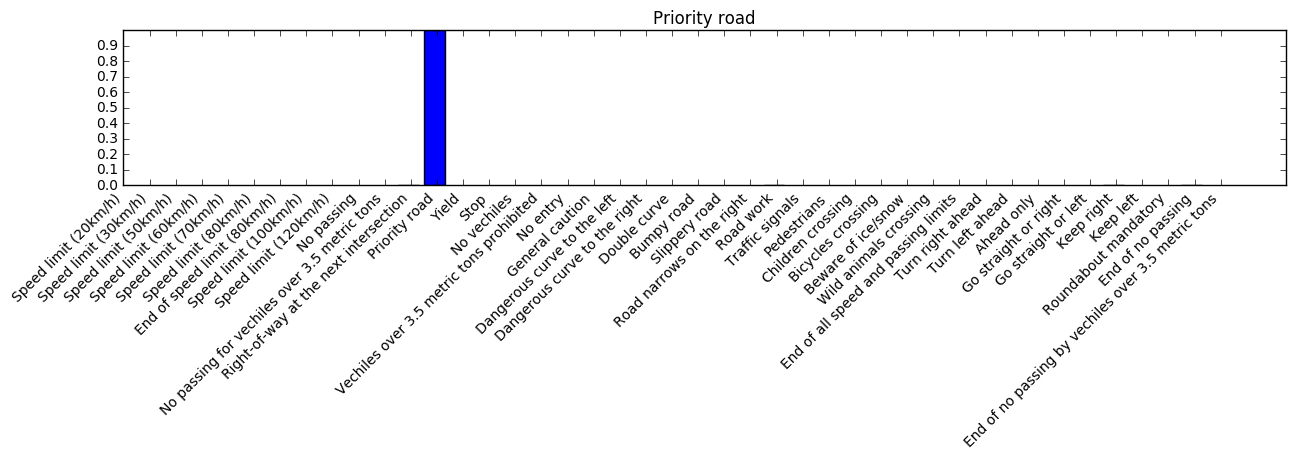

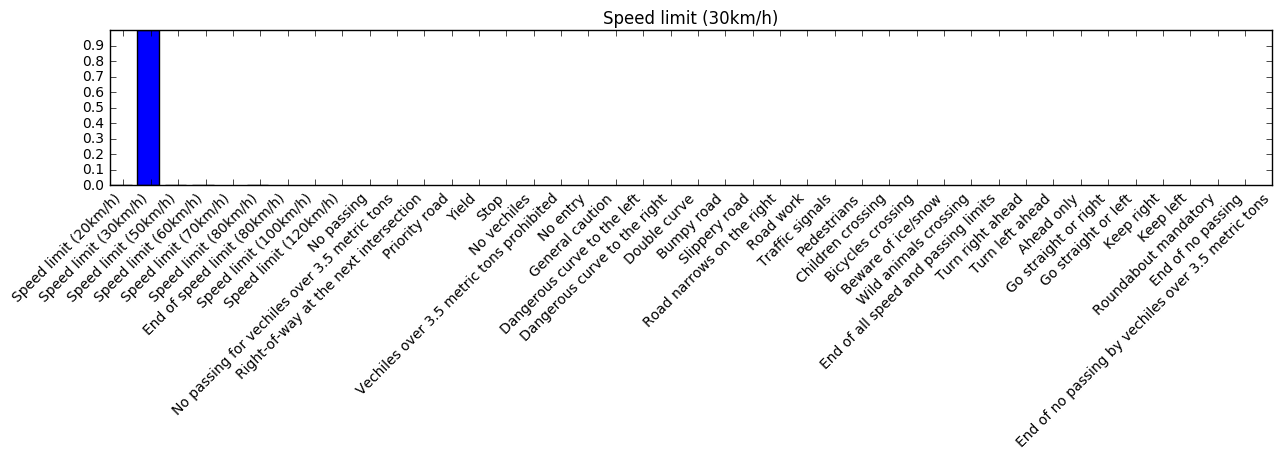

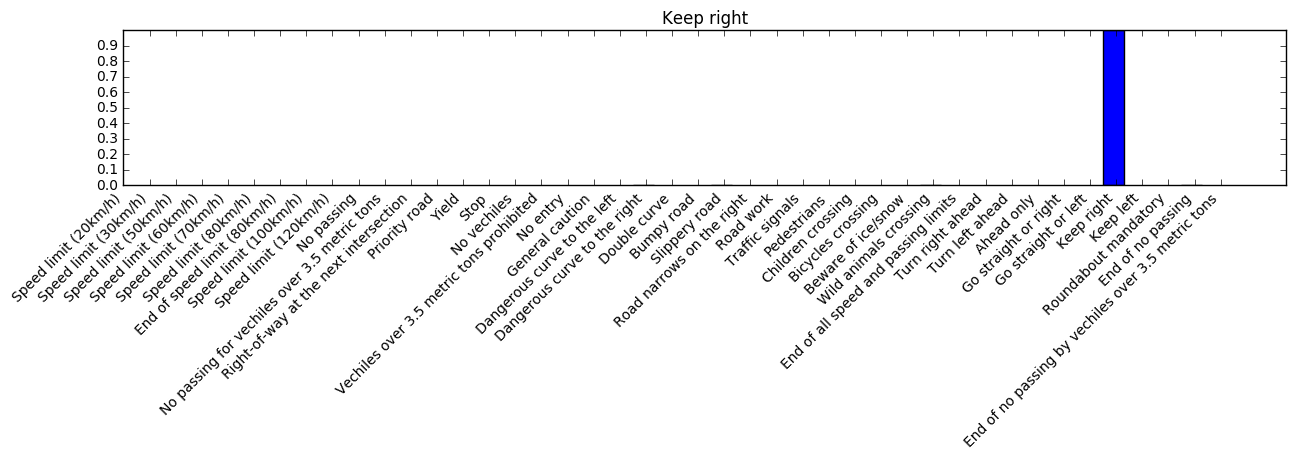

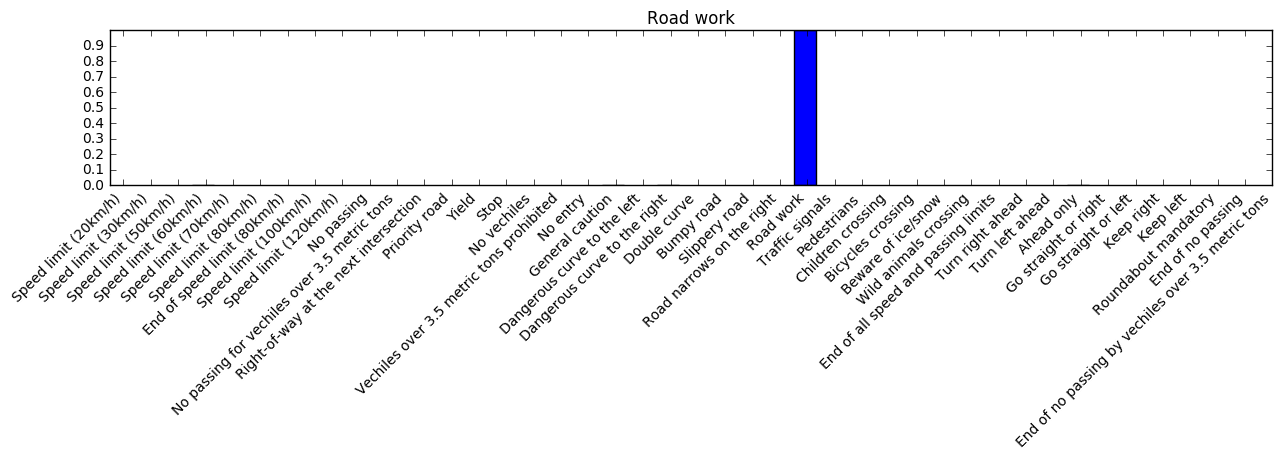

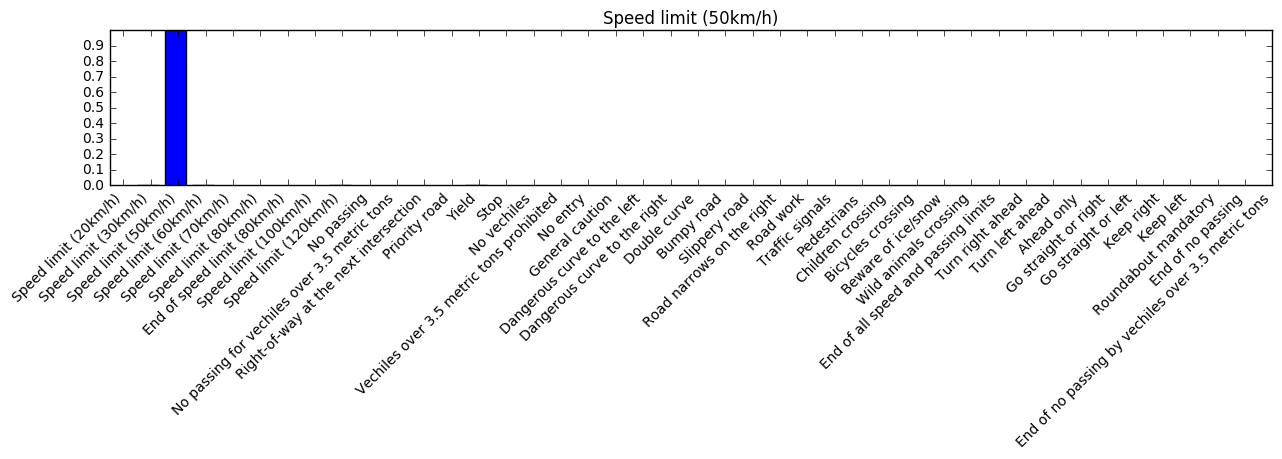

In [19]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for i, (labels, probs) in enumerate(zip(top_predictions.indices, top_predictions.values)):
    plt.figure(figsize=(15, 2))
    plt.bar(labels,probs)
    plt.title(top_labels[i][0])
    # plt.xticks(np.arange(0.5, 43.5, 1.0),np.arange(0, 43, 1))
    plt.xticks(np.arange(0.5, 43.5, 1.0), get_label_map('signnames.csv', np.unique(y_train)),  ha='right', rotation=45)
    plt.yticks(np.arange(0.0,1.0,0.1), np.arange(0.0, 1.0, 0.1))
plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

Yes, the model is quite accurate in it's initial prediction. The probabilities of the correct labels for the images that were chosen were quite high.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
To be able to come up with a model that performs the following approach was taken in this project.

1. Build a Single hidden layer softmax classifier.
2. Look-up references and identify one reference for implementation.
3. Add layers based on the reference and build a working architecture empirically by  repeated training and testing.
4. Make modifications to it different pre-processing techniques.
5. Encapsulate utility functions into a  separate module.
6. Find new images, programmatically annotate and prepare them for testing with model.
7. Test and get the prediction probability and certainties.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.